In [4]:
import ast
import numpy as np
import pandas as pd
import tensorflow as tf
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from matplotlib import pyplot as plt
from keras.utils import to_categorical
from tensorflow.keras.regularizers import L2
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense,GRU,LSTM,Bidirectional,Embedding,Input

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
ds=pd.read_csv('/kaggle/input/named-entity-recognition-ner-corpus/ner.csv')

In [6]:
#converting the tag column to list (it was previously in string format)
ds['POS']=ds['POS'].apply(ast.literal_eval)
ds['Tag']=ds['Tag'].apply(ast.literal_eval)

In [7]:
#cleaning the POS and text column
punctuation="!#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'"
omit=["'s","'ll","--",'"','..']
clean_sentences=[]
clean_tags=[]
for i in range(ds.shape[0]):
    sentence=ds['Sentence'][i].lower()
    tag=ds['POS'][i]
    
    words=sentence.split()
    clean_sentence=[]
    clean_tag=[]
    for j in range(len(words)):
        if words[j] not in punctuation and words[j] not in omit and words[j].isdecimal()!=True and words[j].isnumeric()!=True:
            clean_sentence.append(words[j])
            clean_tag.append(tag[j])
    clean_sentences.append(clean_sentence)
    clean_tags.append(clean_tag)

In [8]:
#determining all the unique pos tags
unq_tags=[]
for sentence in clean_tags:
    for tag in sentence:
        if tag not in unq_tags:
            unq_tags.append(tag)

In [9]:
#encoding the previously text tags into numbers
enc={}
for i in range(len(unq_tags)):
    enc[unq_tags[i]]=i
    
for sentence in clean_tags:
    for idx in range(len(sentence)):
        try:
            sentence[idx]=enc[sentence[idx]]
        except:
            continue

In [10]:
#Determining what should be the max_len when padding
pad_len=([len(clean_sentences[i]) for i in range(len(clean_sentences))])

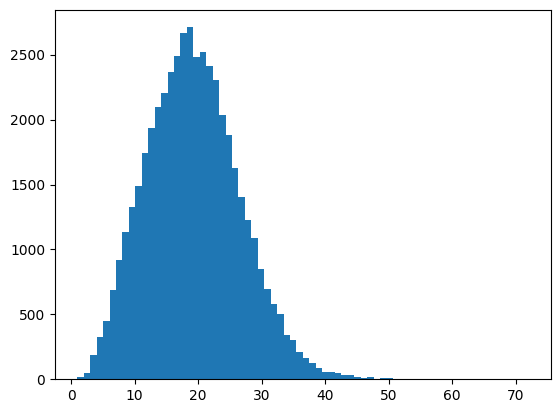

In [11]:
plt.hist(pad_len,bins=70)
plt.show()

In [12]:
#tokenization
tokenizer=Tokenizer(oov_token='<unk>',filters='.')
tokenizer.fit_on_texts(clean_sentences)

In [13]:
w2v_trained=Word2Vec(clean_sentences,vector_size=300,min_count=1)

In [14]:
w2v_trained.save('w2v_pos.model')

In [15]:
#creating the embedding matrix
embedding_matrix=np.zeros((len(tokenizer.word_index)+1,300))
skiped=[]
for word,index in tokenizer.word_index.items():
    try:
        embedding_vec=w2v_trained.wv[word]
    except:
        skiped.append(word)
        continue
    embedding_matrix[index]=embedding_vec

In [16]:
sequences=tokenizer.texts_to_sequences(clean_sentences)

In [17]:
import pickle

with open('/kaggle/working/NER_tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

#with open('tokenizer.pickle', 'rb') as handle:
#    tokenizer = pickle.load(handle)

In [18]:
pad_seq = pad_sequences(sequences, maxlen=30, padding='post')

In [19]:
pad_tag = pad_sequences(clean_tags, maxlen=30, padding='post')

In [20]:
embedding_matrix[1]=np.random.normal(0, 1, (300,))

In [21]:
x_train, x_test, y_train, y_test = train_test_split(pad_seq, pad_tag, test_size=0.15, random_state=42)

In [22]:
y_train_one_hot = to_categorical(y_train, num_classes=39)
y_test_one_hot = to_categorical(y_test, num_classes=39)

In [28]:
lstm_model=Sequential([
    Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=300, input_length=30, trainable=False, weights=[embedding_matrix]),
    Bidirectional(LSTM(512,kernel_regularizer=L2(0.0001),recurrent_regularizer=L2(0.001),return_sequences=True)),
    Dense(39,'softmax')
])

In [29]:
lstm_model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=[Precision(),Recall(),'Accuracy'])

In [30]:
lstm_model.fit(x_train,y_train_one_hot,epochs=7)

Epoch 1/7
1274/1274 [==============================] - 21s 13ms/step - loss: 0.4455 - precision_1: 0.9479 - recall_1: 0.8606 - Accuracy: 0.8978
Epoch 2/7
1274/1274 [==============================] - 17s 13ms/step - loss: 0.2936 - precision_1: 0.9541 - recall_1: 0.9027 - Accuracy: 0.9249
Epoch 3/7
1274/1274 [==============================] - 17s 13ms/step - loss: 0.2655 - precision_1: 0.9566 - recall_1: 0.9114 - Accuracy: 0.9309
Epoch 4/7
1274/1274 [==============================] - 16s 13ms/step - loss: 0.2481 - precision_1: 0.9585 - recall_1: 0.9170 - Accuracy: 0.9349
Epoch 5/7
1274/1274 [==============================] - 16s 13ms/step - loss: 0.2374 - precision_1: 0.9593 - recall_1: 0.9204 - Accuracy: 0.9372
Epoch 6/7
1274/1274 [==============================] - 16s 13ms/step - loss: 0.2294 - precision_1: 0.9602 - recall_1: 0.9230 - Accuracy: 0.9389
Epoch 7/7
1274/1274 [==============================] - 17s 13ms/step - loss: 0.2230 - precision_1: 0.9608 - recall_1: 0.9250 - Accuracy:

In [31]:
lstm_model.evaluate(x_test,y_test_one_hot)

225/225 [==============================] - 2s 7ms/step - loss: 0.2201 - precision_1: 0.9600 - recall_1: 0.9268 - Accuracy: 0.9410


[0.220140278339386, 0.9600491523742676, 0.926846444606781, 0.9409878849983215]

In [33]:
lstm_model.save('lstm_model.h5')

# **Inference**

In [34]:
pred=gru_model.predict(x_test[1101].reshape(30,1))

1/1 [==============================] - 1s 700ms/step


In [73]:
ans=[]
for each in pred:
    m=0
    ind=0
    for i in range(len(each[0])):
        try:
            if each[0][i]>m: 
                m=each[0][i]
                ind=i
        except:
            print(each[i])
    ans.append(ind)

In [77]:
ans,y_test[1101]
np.array(ans)-y_test[1101]

array([ 7,  8, 11, 10,  1, 10,  0,  1,  8,  8,  1,  4,  9,  4,  4,  4, 11,
       10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int32)

In [41]:
with open('enc.pkl','wb') as file:
    pickle.dump(enc,file,protocol=pickle.HIGHEST_PROTOCOL)